In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numba
plt.style.use('ggplot')
%matplotlib inline

In [2]:
class MonteCarlo(object):
    def __init__(self, num_temp, nx, ny):
        self.nx = nx
        self.ny = ny
        self.spin = np.zeros([self.nx, self.ny])
        self.m_mcs = 0
        self.m_square_mcs = 0
        self.m_fourth_mcs = 0
        self.e_mcs = 0
        self.e_square_mcs = 0
        self.e = np.zeros(num_temp)
        self.m = np.zeros(num_temp)
        self.g = np.zeros(num_temp)
        self.c = np.zeros(num_temp)
        self.t_output = 2
        self.px, self.py = self.set_periodic_boundary()
        
    def init_spin(self):
        random_arr = np.random.rand(self.nx, self.ny)
        self.spin = np.where(random_arr > 0.5, 1, -1).astype(np.float64)
        
    def set_periodic_boundary(self):
        px = [i for i in range(self.nx)]
        py = [i for i in range(self.ny)]
        px.extend([0,self.nx -1])
        py.extend([0,self.ny -1])
        px = np.array(px, dtype=np.int64)
        py = np.array(py, dtype=np.int64)
        return px, py
    
    @staticmethod
    @numba.jit(nopython=True)
    def metropolis(spin, j_const, temp, px, py):
        nx, ny = spin.shape
        for y in range(ny):
            for x in range(nx):
                local_h = j_const * (spin[x, py[y-1]] +spin[x, py[y+1]] + spin[px[x-1], y] + spin[px[x+1], y])
                delta_e = 2.0 * local_h * spin[x, y]
                if delta_e < 0:
                    spin[x, y] *= -1
                else:
                    if np.random.rand() < np.exp(-delta_e / temp):
                        spin[x, y] *= -1
                        
    @staticmethod
    @numba.jit(nopython=True)
    def calc_physical_quantities(spin, j_const, px, py):
        nx, ny = spin.shape
        mag = np.sum(spin) / (nx * ny)
        energy = 0.0
        for y in range(ny):
            for x in range(nx):
                local_h = j_const * (spin[x, py[y-1]] +spin[x, py[y+1]] + spin[px[x-1], y] + spin[px[x+1], y])
                energy += local_h * spin[x, y]
        energy *= -0.5
        return mag, energy
    
    def init_physical_quantities(self):
        self.m_mcs = 0
        self.m_square_mcs = 0
        self.m_fourth_mcs = 0
        self.e_mcs = 0
        self.e_square_mcs = 0
        
    def add_physical_quantities(self, mag, energy):
        self.m_mcs += mag
        self.m_square_mcs += mag ** 2
        self.m_fourth_mcs += mag ** 4
        self.e_mcs += energy
        self.e_square_mcs += energy ** 2
        
    def mcs_average(self, num_mcs):
        self.m_mcs /= num_mcs
        self.m_square_mcs /= num_mcs
        self.m_fourth_mcs /= num_mcs
        self.e_mcs /= num_mcs
        self.e_square_mcs /= num_mcs
        
    def calc_physical_quantities_for_phase_transition(self, t, temp):
        self.m[t] = self.m_mcs
        self.e[t] = self.e_mcs / (self.nx * self.ny)
        self.c[t] = (1 / temp) ** 2 * (self.e_square_mcs - self.e_mcs ** 2) / (self.nx * self.ny)
        self.g[t] = 1.5 * (1.0 - self.m_fourth_mcs / (3.0 * self.m_square_mcs ** 2))

In [3]:
t_max = 4.0
t_min = 1.0
num_t = 20
t_arr = np.linspace(t_max, t_min, num_t)

In [4]:
nmcs = int(1e5)
burn_in = int(0.5 * nmcs)
nmcs_eff = nmcs - burn_in

In [5]:
nx, ny = 50, 50

In [6]:
mc = MonteCarlo(num_temp=num_t, nx=nx, ny=ny)

In [7]:
mc.init_spin()

<AxesSubplot:>

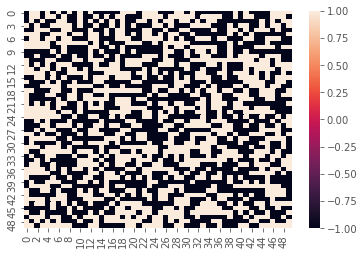

In [8]:
sns.heatmap(mc.spin)

current_temp: 4.0


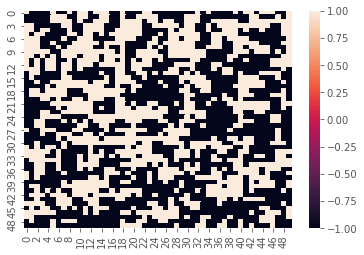

current_temp: 3.8421052631578947
current_temp: 3.6842105263157894


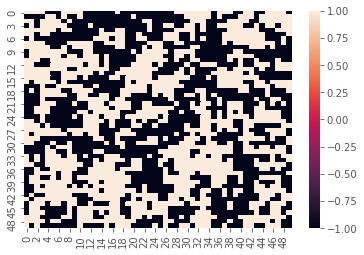

current_temp: 3.526315789473684
current_temp: 3.3684210526315788


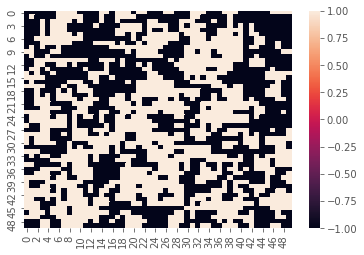

current_temp: 3.2105263157894735
current_temp: 3.0526315789473686


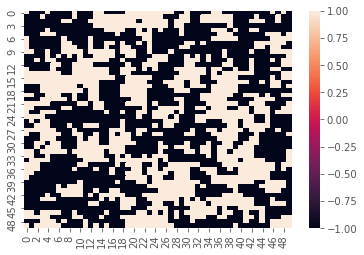

current_temp: 2.8947368421052633
current_temp: 2.736842105263158


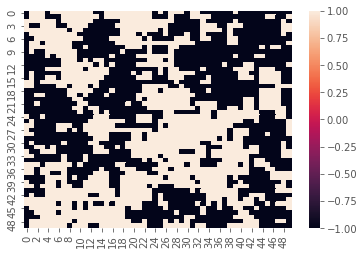

current_temp: 2.5789473684210527
current_temp: 2.4210526315789473


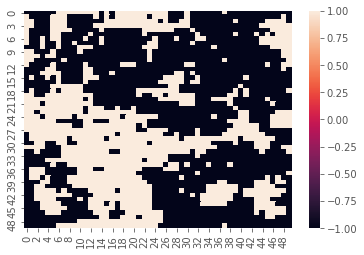

current_temp: 2.2631578947368425
current_temp: 2.105263157894737


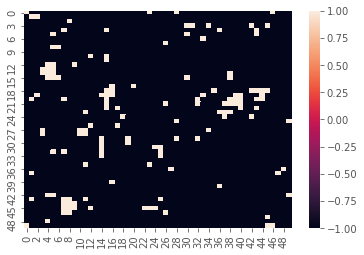

current_temp: 1.9473684210526319
current_temp: 1.7894736842105265


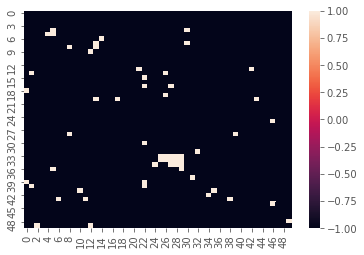

current_temp: 1.6315789473684212
current_temp: 1.473684210526316


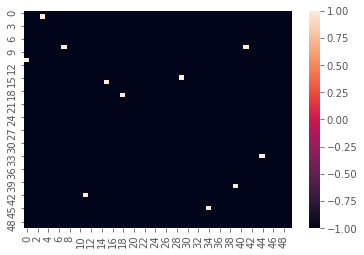

current_temp: 1.3157894736842106
current_temp: 1.1578947368421053


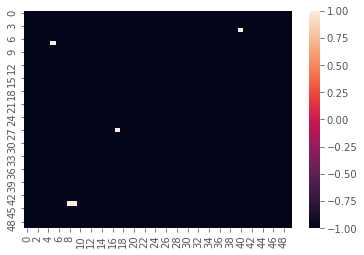

current_temp: 1.0


In [9]:
for tid, temperature in enumerate(t_arr):
    print('current_temp: {}'.format(temperature))
    mc.init_physical_quantities()
    for mcs in range(nmcs):
        mc.metropolis(mc.spin, 1.0, temperature, mc.px, mc.py)
        if mcs >= burn_in:
            m, e = mc.calc_physical_quantities(mc.spin, 1.0, mc.px, mc.py)
            mc.add_physical_quantities(m, e)
    mc.mcs_average(nmcs_eff)
    mc.calc_physical_quantities_for_phase_transition(tid, temperature)
    if tid % mc.t_output == 0:
        sns.heatmap(mc.spin, vmin=-1, vmax=1)
        plt.show()

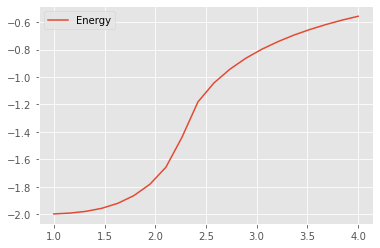

In [10]:
plt.plot(t_arr, mc.e, label='Energy')
plt.legend()

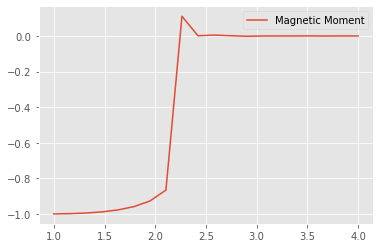

In [11]:
plt.plot(t_arr, mc.m, label='Magnetic Moment')
plt.legend()

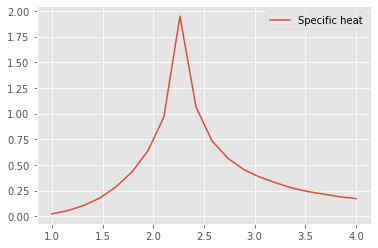

In [12]:
plt.plot(t_arr, mc.c, label='Specific heat')
plt.legend()

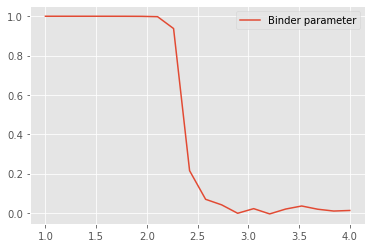

In [13]:
plt.plot(t_arr, mc.g, label='Binder parameter')
plt.legend()